In [2694]:
import pandas as pd
import numpy as np
import copy, math
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from scipy.stats import gaussian_kde
# do not limit number of rows displayed
pd.set_option('display.max_rows', None)

TIMEOUT_THRESHOLD = 600

def set_failed_cases(df):
  # df = df.fillna(0)
  # keep timeout cases before unrolling
  df['pp_to'] = np.where(df['pp_crab_time'].isna(), True, False)
  # kepp timeout cases after unrolling
  df['opsem_to'] = np.where(df['opsem_crab_time'].isna() & df['seahorn_total_time'].isna(), True, False)
  df['result'] = np.where(~df['seahorn_total_time'].isna(), "TRUE", df['result'])
  df['pp.isderef.not.solve'] = np.where(df['pp.isderef.not.solve'].isna() & ~df['pp_to'], 0, df['pp.isderef.not.solve'])
  df['pp.isderef.solve'] = np.where(df['pp.isderef.solve'].isna() & ~df['pp_to'], 0, df['pp.isderef.solve'])
  df['pp_crab_time'] = np.where(df['pp_to'], TIMEOUT_THRESHOLD, df['pp_crab_time'])
  df['pp_crab_time'] = np.where(df['pp_crab_time'].isna() & ~df['pp_to'], 0, df['pp_crab_time'])
  df['opsem.isderef.not.solve'] = np.where(df['opsem.isderef.not.solve'].isna() & ~df['opsem_to'], 0, df['opsem.isderef.not.solve'])
  df['opsem.isderef.solve'] = np.where(df['opsem.isderef.solve'].isna() & ~df['opsem_to'], 0, df['opsem.isderef.solve'])
  df['opsem_crab_time'] = np.where(df['opsem_to'], TIMEOUT_THRESHOLD, df['opsem_crab_time'])
  df['opsem_crab_time'] = np.where(df['opsem_crab_time'].isna() & ~df['opsem_to'], 0, df['opsem_crab_time'])
  df['opsem_to'] = np.where(df['opsem_to'] & ~df['pp_to'], True, df['opsem_to'])
  # after = df.columns.get_loc('result') + 1
  # df.iloc[:, after:] = df.iloc[:, after:].fillna(0)
  # df['result'] = np.where(df['result'] == 0, "FALSE", df['result'])
  return df

def clean_format(csv):
    csv['seahorn_total_time'] = csv['seahorn_total_time'].fillna(0).astype(float)
    csv['bmc_solve_time'] = csv['bmc_solve_time'].fillna(0).astype(float)
    csv['bmc_dag_size'] = csv['bmc_dag_size'].fillna(0).astype(int)
    csv['bmc_circuit_size'] = csv['bmc_circuit_size'].fillna(0).astype(int)
    csv['opsem_crab_time'] = csv['opsem_crab_time'].fillna(0).astype(float)
    csv['opsem_crab_range_time'] = csv['opsem_crab_range_time'].fillna(0).astype(float)
    csv['pp_crab_time'] = csv['pp_crab_time'].fillna(0).astype(float)
    csv['pp_crab_range_time'] = csv['pp_crab_range_time'].fillna(0).astype(float)
    csv['pp.isderef.not.solve'] = csv['pp.isderef.not.solve'].fillna(0).astype(int)
    csv['pp.isderef.solve'] = csv['pp.isderef.solve'].fillna(0).astype(int)
    csv['opsem.isderef.not.solve'] = csv['opsem.isderef.not.solve'].fillna(0).astype(int)
    csv['opsem.isderef.solve'] = csv['opsem.isderef.solve'].fillna(0).astype(int)
    return csv
  
def validate_timeout_statistics(df):
  bpp_to = df[df['pp_to']]
  mask = (bpp_to['pp_crab_time'] == TIMEOUT_THRESHOLD) & bpp_to['pp.isderef.not.solve'].isna() & bpp_to['pp.isderef.solve'].isna()
  assert mask.any(), f"Found unexpected rows:\n{bpp_to[mask]['job_name']}"
  bpp_good = df[~df['pp_to']]
  mask = (bpp_good['pp_crab_time'] <= TIMEOUT_THRESHOLD) & (~bpp_good['pp.isderef.not.solve'].isna()) & (~bpp_good['pp.isderef.solve'].isna())
  assert mask.any(), f"Found unexpected rows:\n{bpp_good[mask]['job_name']}"
  app_to = df[df['opsem_to']]
  mask = (app_to['opsem_crab_time'] == TIMEOUT_THRESHOLD) & app_to['opsem.isderef.not.solve'].isna() & app_to['opsem.isderef.solve'].isna()
  assert mask.any(), f"Found unexpected rows:\n{app_to[mask]['job_name']}"
  app_good = df[~df['opsem_to']]
  mask = (app_good['opsem_crab_time'] <= TIMEOUT_THRESHOLD) & (~app_good['opsem.isderef.not.solve'].isna()) & (~app_good['opsem.isderef.solve'].isna())
  assert mask.any(), f"Found unexpected rows:\n{app_good[mask]['job_name']}"

def check_timeout_cases_same(df1, df2):
  df1 = pd.DataFrame(df1)
  df2 = pd.DataFrame(df2)
  sorted_df1 = df1.sort_values(by='job_name').reset_index(drop=True)
  sorted_df2 = df2.sort_values(by='job_name').reset_index(drop=True)
  res = sorted_df1['job_name'].equals(sorted_df2['job_name'])
  diff_df1 = sorted_df1[~sorted_df1['job_name'].isin(sorted_df2['job_name'])]
  diff_df2 = sorted_df2[~sorted_df2['job_name'].isin(sorted_df1['job_name'])]
  return res, list(diff_df1['job_name']), list(diff_df2['job_name'])

In [ ]:

# load csv file
AWS_CSV_PATH = '../res/vstte/data/'
FIRE_DANCER_PATH = '../../verify-firedancer/res/vstte/data/'
LIVENESS = False
ASSUME_PROVEN = True
ASSUME_PROVEN_AND_CRAB_ONLY = True

def process_csv(csv_name, repo_name):
    CRAB_CSV = f'{csv_name.upper()}.csv'
    if ASSUME_PROVEN:
        CRAB_CSV = f'{csv_name.upper()}(assume).csv'
    if ASSUME_PROVEN_AND_CRAB_ONLY:
        CRAB_CSV = f'{csv_name.upper()}(pure).csv'
    CSV_PATH = AWS_CSV_PATH if repo_name == 'aws' else FIRE_DANCER_PATH
    print("Processing csv file: ", CRAB_CSV)
    crab_csv = set_failed_cases(pd.read_csv(CSV_PATH + CRAB_CSV))
    print(f'Total cases from {repo_name}: {len(crab_csv)}')
    crab_csv = crab_csv.dropna(subset=["result"])
    # crab_csv = clean_format(crab_csv)
    validate_timeout_statistics(crab_csv)
    matches = crab_csv[crab_csv['job_name'] == 'der']
    crab = crab_csv[['job_name', 'pp_crab_time', 'pp_crab_range_time', 'pp.isderef.not.solve', 'pp.isderef.solve', 'opsem_crab_time', 'opsem_crab_range_time', 'opsem.isderef.not.solve', 'opsem.isderef.solve', 'bmc_solve_time', 'seahorn_total_time', 'bmc_circuit_size', 'bmc_dag_size']].rename(columns = {'pp_crab_time': f'{csv_name}_pp_time', 'opsem_crab_time': f'{csv_name}_opsem_time', 'pp.isderef.not.solve': f'{csv_name}_pp_warn', 'pp.isderef.solve': f'{csv_name}_pp_safe', 'opsem.isderef.not.solve': f'{csv_name}_opsem_warn', 'opsem.isderef.solve': f'{csv_name}_opsem_safe', 'seahorn_total_time' : f'{csv_name}_total_time'})
    crab['repo'] = repo_name
    crab[f'{csv_name}_pp_to'] = crab_csv['pp_to']
    crab[f'{csv_name}_opsem_to'] = crab_csv['opsem_to']

    return crab

def compute_stats(crab, csv_name):
    no_is_dref = crab[(~crab[f'{csv_name}_pp_to']) & (crab[f'{csv_name}_pp_warn'] == 0.0) & (crab[f'{csv_name}_pp_safe'] == 0.0)]
    no_is_dref_lst = no_is_dref['job_name'].to_list()
    crab = crab[~crab['job_name'].isin(no_is_dref_lst)] # exclude no isderef cases
    print(f'Total cases with is_deref checks: {len(crab)}')
    crab[f'{csv_name}_pp%'] = round(crab[f'{csv_name}_pp_safe'] / (crab[f'{csv_name}_pp_warn'] + crab[f'{csv_name}_pp_safe']) * 100, 0)
    crab[f'{csv_name}_opsem%'] = round(crab[f'{csv_name}_opsem_safe'] / (crab[f'{csv_name}_opsem_warn'] + crab[f'{csv_name}_opsem_safe']) * 100, 0)
    before_pp_tmlst = crab.loc[crab[f'{csv_name}_pp_to'] == True]['job_name'].to_list()
    after_pp_tmlst = crab.loc[crab[f'{csv_name}_opsem_to'] == True]['job_name'].to_list()
    after_pp_tmlst = list(filter(lambda x: x not in before_pp_tmlst, after_pp_tmlst))
    print(f"{csv_name} before loop unrolling timeouts {len(before_pp_tmlst)} cases: {before_pp_tmlst}")
    print(f"{csv_name} after loop unrolling timeouts {len(after_pp_tmlst)} cases: {after_pp_tmlst}")
    # crab = crab[~crab['job_name'].isin(tmlst)] # exclude timeout cases
    crab['#pp'] = crab[f'{csv_name}_pp_warn'] + crab[f'{csv_name}_pp_safe']
    # crab['#pp'] = crab['#pp'].astype(int)
    crab['#opsem'] = crab[f'{csv_name}_opsem_warn'] + crab[f'{csv_name}_opsem_safe']
    # crab['#opsem'] = crab['#opsem'].astype(int)
    return crab

utvpi = compute_stats(pd.concat([process_csv('utvpi', 'aws'), process_csv('utvpi', 'fire_dancer')], ignore_index=True), 'utvpi')
template_tvpi = compute_stats(pd.concat([process_csv('template_tvpi', 'aws'), process_csv('template_tvpi', 'fire_dancer')], ignore_index=True), 'template_tvpi')
pk = compute_stats(pd.concat([process_csv('pk', 'aws'), process_csv('pk', 'fire_dancer')], ignore_index=True), 'pk')

# merge all csv files
res = pd.merge(utvpi, template_tvpi, how='inner', on='job_name')
res = pd.merge(res, pk, how='inner', on='job_name')
print(f"number of cases: {len(res)}")

Processing csv file:  UTVPI(pure).csv
Total cases from aws: 187
Processing csv file:  UTVPI(pure).csv
Total cases from fire_dancer: 30
Total cases with is_deref checks: 139
utvpi before loop unrolling timeouts 5 cases: ['profile_collection_new_from_buffer', 'ecc', 'waltz_quic_tls_server_hs', 'util_fd_pod_query', 'ballet_chacha20rng_init_delete']
utvpi after loop unrolling timeouts 2 cases: ['byte_cursor_split_on_char_n2', 'huffman_test_transitive_chunked']
Processing csv file:  TEMPLATE_TVPI(pure).csv
Total cases from aws: 187
Processing csv file:  TEMPLATE_TVPI(pure).csv
Total cases from fire_dancer: 30
Total cases with is_deref checks: 139
template_tvpi before loop unrolling timeouts 6 cases: ['huffman_test_transitive_chunked', 'profile_collection_new_from_buffer', 'ecc', 'waltz_quic_tls_server_hs', 'util_fd_pod_query', 'ballet_chacha20rng_init_delete']
template_tvpi after loop unrolling timeouts 2 cases: ['byte_cursor_split_on_char_n2', 'pem_objects_init_from_file_contents']
Process

/tmp/ipykernel_1946912/1545252968.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crab[f'{csv_name}_pp%'] = round(crab[f'{csv_name}_pp_safe'] / (crab[f'{csv_name}_pp_warn'] + crab[f'{csv_name}_pp_safe']) * 100, 0)
/tmp/ipykernel_1946912/1545252968.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crab[f'{csv_name}_opsem%'] = round(crab[f'{csv_name}_opsem_safe'] / (crab[f'{csv_name}_opsem_warn'] + crab[f'{csv_name}_opsem_safe']) * 100, 0)
/tmp/ipykernel_1946912/1545252968.py:42: SettingWithCopyWarnin

In [2696]:
# need to make assertions consistent after loop unrolling
# seahorn will skip assertions check when all assertions are proven
# here we instead change seahorn itself, just simply sum the number of assertions after loop unrolling as proved
for dom in ['template_tvpi', 'pk']:
    res[f'{dom}_opsem_safe'] = np.where((res[f'{dom}_pp_warn'] == 0.0) & (res[f'{dom}_pp_safe'] > 0.0) & ((res[f'{dom}_opsem_warn'] >= 0.0) | (res[f'{dom}_opsem_safe'] >= 0.0)), res[f'utvpi_opsem_safe'] + res[f'utvpi_opsem_warn'], res[f'{dom}_opsem_safe'])

# Precision Seeds

In [2697]:
# check strange cases, is ther any utvpi can prove but template_tvpi cannot?
strange_cases = res[(res['template_tvpi_pp_safe'] - res['utvpi_pp_safe'] < 0)]
strange_cases = None if strange_cases.empty else strange_cases
strange_cases

In [2698]:
strange_cases = res[(res['template_tvpi_pp_safe'] - res['utvpi_pp_safe'] == 0) & (res['template_tvpi_opsem_safe'] - res['utvpi_opsem_safe'] < 0)]
strange_cases = None if strange_cases.empty else strange_cases
strange_cases

In [2699]:
# find out the cases that tvpi can solve but utvpi cannot
diff1 = res[(res['template_tvpi_pp_safe'] - res['utvpi_pp_safe'] > 0)]
print(f"tvpi can solve at pp level but utvpi cannot: {len(diff1)}")
diff1[['job_name', 'utvpi_pp_warn', 'utvpi_pp_safe', 'template_tvpi_pp_warn', 'template_tvpi_pp_safe', 'pk_pp_warn', 'pk_pp_safe']]

tvpi can solve at pp level but utvpi cannot: 14


,job_name,utvpi_pp_warn,utvpi_pp_safe,template_tvpi_pp_warn,template_tvpi_pp_safe,pk_pp_warn,pk_pp_safe
4,array_list_swap,2.0,0.0,0.0,2.0,0.0,2.0
18,hash_iter_delete,4.0,45.0,3.0,46.0,3.0,46.0
22,hash_table_clean_up,4.0,35.0,0.0,39.0,0.0,39.0
23,hash_table_clear,4.0,32.0,0.0,36.0,0.0,36.0
24,hash_table_create,18.0,41.0,17.0,42.0,17.0,42.0
27,hash_table_put,26.0,43.0,25.0,44.0,25.0,44.0
28,hash_table_remove,14.0,47.0,13.0,48.0,13.0,48.0
90,hash_iter_begin_done2,2.0,22.0,1.0,23.0,1.0,23.0
101,hash_table_foreach_deep_precise,5.0,31.0,4.0,32.0,4.0,32.0
114,tango_tcache_bounds_query,1.0,0.0,0.0,1.0,0.0,1.0


In [2700]:
diff2 = res[(res['template_tvpi_pp_safe'] - res['utvpi_pp_safe'] == 0) & (res['template_tvpi_opsem_safe'] - res['utvpi_opsem_safe'] > 0)]
print(f"tvpi can solve at opsem level but utvpi cannot: {len(diff2)}")
diff2[['job_name', 'utvpi_opsem_warn', 'utvpi_opsem_safe', 'template_tvpi_opsem_warn', 'template_tvpi_opsem_safe']]

tvpi can solve at opsem level but utvpi cannot: 7


,job_name,utvpi_opsem_warn,utvpi_opsem_safe,template_tvpi_opsem_warn,template_tvpi_opsem_safe
19,hash_table_eq,593.0,469.0,587.0,475.0
85,hash_iter_done2,1.0,31.0,0.0,32.0
87,hash_iter_begin2,32.0,20.0,0.0,52.0
88,hash_table_find2,71.0,83.0,70.0,84.0
89,hash_iter_next2,10.0,31.0,9.0,32.0
100,hash_table_foreach_deep_loose,65.0,65.0,63.0,67.0
121,tango_fctl_bounds_cfg_rx_add_done,45.0,7.0,18.0,34.0


In [2701]:
diff3 = res[(res['pk_pp_safe'] - res['template_tvpi_pp_safe'] > 0)]
print(f"pk can solve at pp level but tvpi cannot: {len(diff3)}")
diff3['pp_diff'] = diff3['pk_pp_safe'] - diff3['template_tvpi_pp_safe']
print(f"The number of diff checks at pp level: {diff3['pp_diff'].sum()}")
diff3[['job_name', 'pk_pp_warn', 'pk_pp_safe', 'template_tvpi_pp_warn', 'template_tvpi_pp_safe']]

pk can solve at pp level but tvpi cannot: 3
The number of diff checks at pp level: 9.0


/tmp/ipykernel_1946912/62669742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff3['pp_diff'] = diff3['pk_pp_safe'] - diff3['template_tvpi_pp_safe']


,job_name,pk_pp_warn,pk_pp_safe,template_tvpi_pp_warn,template_tvpi_pp_safe
75,byte_cursor_compare_lookup2,0.0,4.0,2.0,2.0
76,byte_cursor_trim_pred2,0.0,2.0,2.0,0.0
121,tango_fctl_bounds_cfg_rx_add_done,0.0,5.0,5.0,0.0


- `hash_byte_cursor_ptr` is the case that not related to TVPI
Loop invariants go imprecise on `hashlittle2` method loop `520 - 528`
but why zones and tvpi cause imprecise?
widening? assume_ref? or requiring x + y + z <= c?
```c
    const uint32_t *k = ...; /* read 32-bit chunks */
    while (length > 12)
    {
      k[0]; k[1]; k[2];
      length -= 12;
      k += 3;
    }
```

- `byte_cursor_compare_lookup2` is the case that not related to TVPI
Loop invariants go imprecise on `aws_byte_cursor_compare_lookup` method for loop
aws-c-common/source/byte_buf.c:916:36
but why zones and tvpi cause imprecise?
widening? assume_ref? or requiring x + y + z <= c?
```c
    // Pre: 0 <= len <= 10
    //      ptr.offset = 0
    int start = 0;
    int end = len;
    while(start < len) {
        foo(*ptr);
        ++start;
        ++ptr;
    }
```

- `byte_cursor_trim_pred2` still not
Loop invariants go imprecise on `aws_byte_cursor_left_trim_pred`
```c
    // Pre: 0 <= len <= 10
    //      ptr.offset = 0
    int i = len;
    // Invariant at loop head:
    //    (1) 0 <= i <= len
    //    (2) ptr.offset + i = len
    //    (3) 0 <= ptr.offset <= 10
    while (i > 0 && foo(*ptr)) {
        // Maintenance of (1):
        //   i > 0 => i >= 1, and i <= len (obviously)
        // Maintenance of (2):
        //   <new> ptr.offset = <old> ptr.offset + 1
        //   <new> i = <old> i - 1
        //   so <new> ptr.offset = <old> ptr.offset + 1 = len - <old> i + 1 = len - <new> i
        // Maintenance of (3):
        //   since <new> ptr.offset + <new> i = len
        --i;
        ++ptr;
    }
```
- `tango_fctl_bounds_cfg_rx_add_done`:
    - template TVPI assign transfer function is limited. 
        - Like `x:=e` can be extended to `2x:=2*e`, and so on. However, adapting such cases require more careful design.

In [2702]:
diff4 = res[(res['template_tvpi_pp_safe'] - res['pk_pp_safe'] <= 0) & (res['pk_opsem_safe'] - res['template_tvpi_opsem_safe'] > 0)]
print(f"pk can solve at opsem level but tvpi cannot: {len(diff4)}")
diff4['opsem_diff'] = diff4['pk_opsem_safe'] - diff4['template_tvpi_opsem_safe']
print(f"The number of diff checks at pp level: {diff4['opsem_diff'].sum()}")
diff4[['job_name', 'pk_opsem_warn', 'pk_opsem_safe', 'template_tvpi_opsem_warn', 'template_tvpi_opsem_safe']]

pk can solve at opsem level but tvpi cannot: 5
The number of diff checks at pp level: 59.0


/tmp/ipykernel_1946912/3502764935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff4['opsem_diff'] = diff4['pk_opsem_safe'] - diff4['template_tvpi_opsem_safe']


,job_name,pk_opsem_warn,pk_opsem_safe,template_tvpi_opsem_warn,template_tvpi_opsem_safe
75,byte_cursor_compare_lookup2,0.0,44.0,3.0,41.0
76,byte_cursor_trim_pred2,0.0,12.0,10.0,2.0
101,hash_table_foreach_deep_precise,63.0,81.0,65.0,79.0
121,tango_fctl_bounds_cfg_rx_add_done,0.0,52.0,18.0,34.0
125,util_fd_hash,0.0,130.0,26.0,104.0


- `hash_table_foreach_deep_precise`: 
    - template TVPI assign transfer function is limited. 
        - Like `x:=e` can be extended to `2x:=2*e`, and so on. However, adapting such cases require more careful design.
- `util_fd_hash`:

In [2703]:
# strange case
# Can tvpi solve but pk cannot?
diff5 = res[(res['pk_pp_safe'] - res['template_tvpi_pp_safe'] < 0)]
print(f"tvpi can solve at pp level but pk cannot: {len(diff5)}")
# compute summarize of assertions that pk can solve but tvpi cannot
diff5['pp_diff'] = diff5['template_tvpi_pp_safe'] - diff5['pk_pp_safe']
print(diff5['pp_diff'].sum())
diff5[['job_name', 'pk_pp_warn', 'pk_pp_safe', 'template_tvpi_pp_warn', 'template_tvpi_pp_safe', 'pk_opsem_warn', 'pk_opsem_safe', 'template_tvpi_opsem_warn', 'template_tvpi_opsem_safe']]

/tmp/ipykernel_1946912/1548954037.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff5['pp_diff'] = diff5['template_tvpi_pp_safe'] - diff5['pk_pp_safe']


tvpi can solve at pp level but pk cannot: 4
79.0


,job_name,pk_pp_warn,pk_pp_safe,template_tvpi_pp_warn,template_tvpi_pp_safe,pk_opsem_warn,pk_opsem_safe,template_tvpi_opsem_warn,template_tvpi_opsem_safe
105,pem_objects_init_from_file_contents,323.0,2.0,287.0,38.0,NaN,NaN,NaN,NaN
106,sanitize_pem,13.0,12.0,6.0,19.0,NaN,NaN,58.0,818.0
135,ballet_txn_parse,110.0,16.0,98.0,28.0,42.0,80.0,16.0,106.0
136,ballet_txn_parse_minsz,118.0,5.0,94.0,29.0,0.0,119.0,0.0,119.0


- `pem_objects_init_from_file_contents`
    - ELINA reported overflow exception
    - both zones and template tvpi get the same precision
- `sanitize_pem`:
    - ELINA reported no exception raised
    - both zones and template tvpi get the same precision
    - Elina and apron version both get imprecise results
    - pplite version gets what zones and template TVPI claimed
- `ballet_txn_parse`:
- `ballet_txn_parse_minsz`:
    - ELINA reported exception vector product and overflow exception 
    - both zones and template tvpi get the same precision


In [2704]:
diff6 = res[(res['pk_opsem_safe'] - res['template_tvpi_opsem_safe'] < 0)]
print(f"tvpi can solve at opsem level but pk cannot: {len(diff6)}")
diff6['pp_diff'] = diff6['template_tvpi_opsem_safe'] - diff6['pk_opsem_safe']
print(diff6['pp_diff'].sum())
diff6[['job_name', 'pk_pp_warn', 'pk_pp_safe', 'template_tvpi_pp_warn', 'template_tvpi_pp_safe', 'pk_opsem_warn', 'pk_opsem_safe', 'template_tvpi_opsem_warn', 'template_tvpi_opsem_safe']]

tvpi can solve at opsem level but pk cannot: 4
52.0


/tmp/ipykernel_1946912/1949935663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff6['pp_diff'] = diff6['template_tvpi_opsem_safe'] - diff6['pk_opsem_safe']


,job_name,pk_pp_warn,pk_pp_safe,template_tvpi_pp_warn,template_tvpi_pp_safe,pk_opsem_warn,pk_opsem_safe,template_tvpi_opsem_warn,template_tvpi_opsem_safe
108,der,275.0,298.0,275.0,298.0,858.0,128.0,838.0,148.0
122,waltz_quic_decode_initial,9.0,6.0,9.0,6.0,2.0,51.0,0.0,53.0
129,util_fd_bits_svw,9.0,3.0,9.0,3.0,9.0,3.0,5.0,7.0
135,ballet_txn_parse,110.0,16.0,98.0,28.0,42.0,80.0,16.0,106.0


- `der`
    - ELINA reported exception vector product
    - both zones and template tvpi get the same precision
- `waltz_quic_decode_initial`
    - ELINA reported exception vector product and overflow exception
    - pplite version gets what zones and template TVPI claimed
- `util_fd_bits_svw`
    - ELINA reported overflow exception
    - Apron and pplite versions get what zones and template TVPI claimed
- `ballet_txn_parse`
    - ss

In [2705]:
# How many cases that both tvpi and pk solve the same but not utvpi?
diff7 = res[(res['template_tvpi_pp_safe'] - res['pk_pp_safe'] == 0) & (res['utvpi_pp_safe'] - res['pk_pp_safe'] != 0)]
diff7[['job_name', 'utvpi_opsem_warn', 'utvpi_opsem_safe', 'template_tvpi_opsem_warn', 'template_tvpi_opsem_safe']]

,job_name,utvpi_opsem_warn,utvpi_opsem_safe,template_tvpi_opsem_warn,template_tvpi_opsem_safe
4,array_list_swap,2.0,0.0,0.0,2.0
18,hash_iter_delete,12.0,52.0,11.0,53.0
22,hash_table_clean_up,40.0,105.0,0.0,145.0
23,hash_table_clear,40.0,102.0,0.0,142.0
24,hash_table_create,75.0,91.0,74.0,92.0
27,hash_table_put,78.0,97.0,77.0,98.0
28,hash_table_remove,50.0,76.0,49.0,77.0
90,hash_iter_begin_done2,64.0,55.0,0.0,119.0
101,hash_table_foreach_deep_precise,67.0,77.0,65.0,79.0
114,tango_tcache_bounds_query,12.0,0.0,0.0,12.0


In [2706]:
diff8 = res[(res['template_tvpi_opsem_safe'] - res['pk_opsem_safe'] == 0) & (res['utvpi_opsem_safe'] - res['pk_opsem_safe'] != 0) & (~res['job_name'].isin(diff7['job_name']))]
diff8[['job_name', 'utvpi_pp_warn', 'utvpi_pp_safe', 'template_tvpi_pp_warn', 'template_tvpi_pp_safe', 'utvpi_opsem_warn', 'utvpi_opsem_safe', 'template_tvpi_opsem_warn', 'template_tvpi_opsem_safe']]

,job_name,utvpi_pp_warn,utvpi_pp_safe,template_tvpi_pp_warn,template_tvpi_pp_safe,utvpi_opsem_warn,utvpi_opsem_safe,template_tvpi_opsem_warn,template_tvpi_opsem_safe
19,hash_table_eq,11.0,51.0,11.0,51.0,593.0,469.0,587.0,475.0
85,hash_iter_done2,1.0,31.0,1.0,31.0,1.0,31.0,0.0,32.0
87,hash_iter_begin2,1.0,19.0,1.0,19.0,32.0,20.0,0.0,52.0
89,hash_iter_next2,2.0,31.0,2.0,31.0,10.0,31.0,9.0,32.0
100,hash_table_foreach_deep_loose,4.0,27.0,4.0,27.0,65.0,65.0,63.0,67.0


In [2707]:
# total number of cases
print(f"Total number of cases: {len(diff7) + len(diff8)}")

Total number of cases: 18


# Performance Seed

In [2708]:
perf = res[~res['utvpi_opsem_to'] & ~res['template_tvpi_opsem_to'] & ~res['pk_opsem_to']]

In [2709]:
# pp time statistics
stats = perf[['template_tvpi_pp_time', 'pk_pp_time', 'utvpi_pp_time']].describe().round(1)
print(stats)

       template_tvpi_pp_time  pk_pp_time  utvpi_pp_time
count                  123.0       123.0          123.0
mean                     0.4         2.5            0.2
std                      1.9        15.0            0.6
min                      0.0         0.0            0.0
25%                      0.0         0.1            0.0
50%                      0.0         0.2            0.0
75%                      0.1         0.5            0.1
max                     19.4       165.1            4.2


In [2710]:
# opsem time statistics
stats = perf[['template_tvpi_opsem_time', 'pk_opsem_time', 'utvpi_opsem_time']].describe().round(1)
print(stats)

       template_tvpi_opsem_time  pk_opsem_time  utvpi_opsem_time
count                     123.0          123.0             123.0
mean                        0.2            2.2               0.1
std                         0.7            7.4               0.5
min                         0.0            0.0               0.0
25%                         0.0            0.0               0.0
50%                         0.0            0.1               0.0
75%                         0.0            0.2               0.0
max                         5.2           50.2               4.0


In [2711]:
# check performance of tvpi increased
diff7 = res[res['template_tvpi_pp_time'] - res['utvpi_pp_time'] > 0.5]
print(f"tvpi pp time is greater than utvpi pp time: {len(diff7)}")
diff7[['job_name', 'utvpi_pp_time', 'template_tvpi_pp_time', 'pk_pp_time']]

tvpi pp time is greater than utvpi pp time: 11


,job_name,utvpi_pp_time,template_tvpi_pp_time,pk_pp_time
19,hash_table_eq,2.85,3.36,13.36
101,hash_table_foreach_deep_precise,1.07,2.15,14.06
102,huffman_test_transitive,1.66,5.80,600.00
103,huffman_test_transitive_chunked,26.52,600.00,600.00
105,pem_objects_init_from_file_contents,28.57,32.42,275.46
108,der,4.22,4.90,165.10
113,sha256_hmac,0.93,1.47,10.07
121,tango_fctl_bounds_cfg_rx_add_done,0.20,1.10,1.75
135,ballet_txn_parse,3.47,19.40,9.80
136,ballet_txn_parse_minsz,2.03,3.46,5.57


In [2712]:
diff8 = res[res['template_tvpi_opsem_time'] - res['utvpi_opsem_time'] > 0.5]
print(f"tvpi opsem time is greater than utvpi opsem time: {len(diff8)}")
diff8[['job_name', 'utvpi_opsem_time', 'template_tvpi_opsem_time', 'pk_opsem_time']]

tvpi opsem time is greater than utvpi opsem time: 10


,job_name,utvpi_opsem_time,template_tvpi_opsem_time,pk_opsem_time
19,hash_table_eq,4.04,5.24,24.86
88,hash_table_find2,0.57,1.35,600.00
102,huffman_test_transitive,1.11,3.38,600.00
105,pem_objects_init_from_file_contents,36.11,600.00,600.00
106,sanitize_pem,6.61,9.54,600.00
108,der,3.08,4.86,27.47
110,rsa,2.42,3.42,600.00
115,tango_tcache_bounds_insert,1.43,3.95,600.00
131,util_fd_pod_iter,21.70,24.14,600.00
135,ballet_txn_parse,0.18,1.51,50.24


In [2713]:
diff9 = res[res['template_tvpi_pp_time'] - res['pk_pp_time'] > 0.5]
print(f"tvpi pp time is greater than pk pp time: {len(diff9)}")
diff9[['job_name', 'utvpi_pp_time', 'template_tvpi_pp_time', 'pk_pp_time']]

tvpi pp time is greater than pk pp time: 1


,job_name,utvpi_pp_time,template_tvpi_pp_time,pk_pp_time
135,ballet_txn_parse,3.47,19.4,9.8


- `ballet_txn_parse`:
    - The most cost operation is join
    - Why it slows, because the edges > 20k, 
    - limitation1: too many ghost variables generated. I provided a coefficient template with 10 heuristics numbers
        - This case, introduced more than I expect. You can think about most of TVPI constraints are useless
        - Removing redundant constraints might help
        - avoid big coefficient template. Maybe less than 5.
    - limitation2: the join of graph did not optimize for operator|= (self join)
       - This join instead maybe can be achieved by remove edges instead of building a new graph

In [2714]:
diff10 = res[res['template_tvpi_opsem_time'] - res['pk_opsem_time'] > 0.5]
print(f"tvpi opsem time is greater than pk opsem time: {len(diff10)}")
diff10[['job_name', 'utvpi_opsem_time', 'template_tvpi_opsem_time', 'pk_opsem_time']]

tvpi opsem time is greater than pk opsem time: 0


,job_name,utvpi_opsem_time,template_tvpi_opsem_time,pk_opsem_time


In [2715]:
# test time increase ratio average
print(f"tvpi pp time increase ratio: {round(diff7['template_tvpi_pp_time'].mean() / diff7['utvpi_pp_time'].mean(), 2)}")
print(f"tvpi opsem time increase ratio: {round(diff8['template_tvpi_opsem_time'].mean() / diff8['utvpi_opsem_time'].mean(), 2)}")
print(f"pk pp time increase ratio: {round(diff3['pk_pp_time'].mean() / diff3['template_tvpi_pp_time'].mean(), 2)}")
print(f"pk opsem time increase ratio: {round(diff4['pk_opsem_time'].mean() / diff4['template_tvpi_opsem_time'].mean(), 2)}")

tvpi pp time increase ratio: 9.17
tvpi opsem time increase ratio: 8.51
pk pp time increase ratio: 1.78
pk opsem time increase ratio: 3.92


In [2716]:
# Find out the cases that template TVPI and UTVPI show the largest time difference
diff11 = res[(res['template_tvpi_pp_time'] - res['utvpi_pp_time']).abs() > 0.5]
# Sort by the absolute difference
diff11 = diff11.sort_values(by='template_tvpi_pp_time', ascending=False)
diff11[['job_name', 'utvpi_pp_time', 'template_tvpi_pp_time', 'pk_pp_time']]

,job_name,utvpi_pp_time,template_tvpi_pp_time,pk_pp_time
103,huffman_test_transitive_chunked,26.52,600.00,600.00
105,pem_objects_init_from_file_contents,28.57,32.42,275.46
135,ballet_txn_parse,3.47,19.40,9.80
102,huffman_test_transitive,1.66,5.80,600.00
108,der,4.22,4.90,165.10
136,ballet_txn_parse_minsz,2.03,3.46,5.57
19,hash_table_eq,2.85,3.36,13.36
137,ballet_chacha20_block,2.35,3.36,600.00
101,hash_table_foreach_deep_precise,1.07,2.15,14.06
113,sha256_hmac,0.93,1.47,10.07


In [2717]:
diff12 = res[(res['template_tvpi_opsem_time'] - res['utvpi_opsem_time']).abs() > 0.5]
# Sort by the absolute difference
diff12 = diff12.sort_values(by='template_tvpi_pp_time', ascending=False)
diff12[['job_name', 'utvpi_opsem_time', 'template_tvpi_opsem_time', 'pk_opsem_time']]

,job_name,utvpi_opsem_time,template_tvpi_opsem_time,pk_opsem_time
105,pem_objects_init_from_file_contents,36.11,600.00,600.00
135,ballet_txn_parse,0.18,1.51,50.24
102,huffman_test_transitive,1.11,3.38,600.00
108,der,3.08,4.86,27.47
19,hash_table_eq,4.04,5.24,24.86
110,rsa,2.42,3.42,600.00
106,sanitize_pem,6.61,9.54,600.00
88,hash_table_find2,0.57,1.35,600.00
131,util_fd_pod_iter,21.70,24.14,600.00
115,tango_tcache_bounds_insert,1.43,3.95,600.00


In [2718]:
# #template_tvpi_single_graph + template_tvpi_two_graphs
# compare_csv = pd.merge(template_tvpi_single_graph, template_tvpi_two_graphs, how='inner', on='job_name', suffixes=('_sg', '_tgs'))
# compare_csv = pd.merge(compare_csv, utvpi, how='inner', on='job_name')
# compare_csv = pd.merge(compare_csv, pk, how='inner', on='job_name')

# # check pp solve difference
# diff13 = compare_csv[(compare_csv['template_tvpi_pp_safe_sg'] - compare_csv['template_tvpi_pp_safe_tgs'] > 0)]
# diff13

In [2719]:
# diff14 = compare_csv[(compare_csv['template_tvpi_pp_safe_sg'] - compare_csv['template_tvpi_pp_safe_tgs'] == 0) & (compare_csv['template_tvpi_opsem_safe_sg'] - compare_csv['template_tvpi_opsem_safe_tgs'] > 0)]
# diff14

In [2720]:
# stats = compare_csv[['template_tvpi_pp_time_sg', 'template_tvpi_pp_time_tgs', 'utvpi_pp_time', 'pk_pp_time']].describe().round(1)
# print(stats)

In [2721]:
# running time difference
# stats = compare_csv[['template_tvpi_opsem_time_sg', 'template_tvpi_opsem_time_tgs', 'utvpi_opsem_time', 'pk_opsem_time']].describe().round(1)
# print(stats)

In [2722]:
# show seeds about difference
# diff15 = compare_csv[(compare_csv['template_tvpi_pp_time_sg'] - compare_csv['template_tvpi_pp_time_tgs']).abs() > 0.5]

# diff15[['job_name', 'template_tvpi_pp_time_sg', 'template_tvpi_pp_time_tgs', 'utvpi_pp_time', 'pk_pp_time']].sort_values(by='template_tvpi_pp_time_sg', ascending=False)

In [2723]:
# diff16 = compare_csv[(compare_csv['template_tvpi_opsem_time_sg'] - compare_csv['template_tvpi_opsem_time_tgs']).abs() > 0.5]
# diff16[['job_name', 'template_tvpi_opsem_time_sg', 'template_tvpi_opsem_time_tgs', 'utvpi_opsem_time', 'pk_opsem_time']].sort_values(by='template_tvpi_opsem_time_sg', ascending=False)

# Table Generation


In [2724]:
dom_names = ["utvpi", "template_tvpi", "pk"]
categories = {
    "aws": ["array_list", "hash_table", "others"],
    "fire_dancer": ["tango", "util", "others"],
    "all": ["total"]
}

def get_assert_rate(df):
    # excluding timeout cases so that all domains have results
    df = df[~df['utvpi_opsem_to'] & ~df['template_tvpi_opsem_to'] & ~df['pk_opsem_to']]
    records = []
    for repo_name, cats in categories.items():
        for c in cats:
            row = {"category": c}
            if c == "others":
                ft = df[df["repo"] == repo_name]
                prefixes = tuple(cats[:-1])  # all but "others"
                ftd = ft[~ft["job_name"].str.startswith(prefixes, na=False)]
            elif c == "total":
                ftd = df
            else:
                ft = df[df["repo"] == repo_name]
                ftd = ft[ft["job_name"].str.startswith(c, na=False)]
            for prefix in ["pp", "opsem"]:
                for dom in dom_names:
                    total = (ftd[f"{dom}_{prefix}_warn"].astype(int)
                        + ftd[f"{dom}_{prefix}_safe"].astype(int)).sum()
                    proved = ftd[f"{dom}_{prefix}_safe"].astype(int).sum()
                    rate   = int(round(proved / total * 100, 0)) if total else 0
                    rate = f"{rate}%"

                    row[f"{dom}_{prefix}_assert"] = total
                    row[f"{dom}_{prefix}_proved"] = proved
                    row[f"{dom}_{prefix}_%"]      = rate
            records.append(row)

    # wrap in a single-element list so we get a one‐row DataFrame
    return pd.DataFrame(records)

precision = get_assert_rate(res)
# add extra columns
precision['empty1'] = ''
precision['empty2'] = ''

##ds

In [2725]:
precision[['category', 'utvpi_pp_assert', 'utvpi_pp_proved', 'utvpi_pp_%', 'template_tvpi_pp_assert', 'template_tvpi_pp_proved', 'template_tvpi_pp_%', 'pk_pp_assert', 'pk_pp_proved', 'pk_pp_%']]

,category,utvpi_pp_assert,utvpi_pp_proved,utvpi_pp_%,template_tvpi_pp_assert,template_tvpi_pp_proved,template_tvpi_pp_%,pk_pp_assert,pk_pp_proved,pk_pp_%
0,array_list,24,18,75%,24,20,83%,24,20,83%
1,hash_table,498,411,83%,498,423,85%,498,423,85%
2,others,1689,1127,67%,1689,1129,67%,1689,1133,67%
3,tango,33,12,36%,33,28,85%,33,33,100%
4,util,106,66,62%,106,66,62%,106,66,62%
5,others,270,66,24%,270,66,24%,270,30,11%
6,total,2620,1700,65%,2620,1732,66%,2620,1705,65%


In [2726]:
precision[['category', 'utvpi_opsem_assert', 'utvpi_opsem_proved', 'utvpi_opsem_%', 'template_tvpi_opsem_assert', 'template_tvpi_opsem_proved', 'template_tvpi_opsem_%', 'pk_opsem_assert', 'pk_opsem_proved', 'pk_opsem_%']]

,category,utvpi_opsem_assert,utvpi_opsem_proved,utvpi_opsem_%,template_tvpi_opsem_assert,template_tvpi_opsem_proved,template_tvpi_opsem_%,pk_opsem_assert,pk_opsem_proved,pk_opsem_%
0,array_list,62,38,61%,62,40,65%,62,40,65%
1,hash_table,2171,1163,54%,2171,1256,58%,2171,1258,58%
2,others,2853,1593,56%,2853,1692,59%,2853,1685,59%
3,tango,151,25,17%,157,133,85%,151,151,100%
4,util,195,147,75%,195,147,75%,195,169,87%
5,others,305,289,95%,305,289,95%,305,261,86%
6,total,5737,3255,57%,5743,3557,62%,5737,3564,62%


In [2727]:
table = precision[['category', 'empty1', 'utvpi_pp_assert', 'utvpi_pp_%', 'template_tvpi_pp_%', 'pk_pp_%', 'empty2', 'utvpi_opsem_assert', 'utvpi_opsem_%', 'template_tvpi_opsem_%', 'pk_opsem_%']]
for col in ['utvpi_pp_%', 'template_tvpi_pp_%', 'pk_pp_%', 'utvpi_opsem_%', 'template_tvpi_opsem_%', 'pk_opsem_%']:
    table[col] = table[col].str.replace('%', r'\%')
table['category'] = table['category'].str.replace('_', r'\_')

print(table.to_latex(escape=False, index=False))

\begin{tabular}{llrllllrlll}
\toprule
category & empty1 & utvpi_pp_assert & utvpi_pp_% & template_tvpi_pp_% & pk_pp_% & empty2 & utvpi_opsem_assert & utvpi_opsem_% & template_tvpi_opsem_% & pk_opsem_% \\
\midrule
array\_list &  & 24 & 75\% & 83\% & 83\% &  & 62 & 61\% & 65\% & 65\% \\
hash\_table &  & 498 & 83\% & 85\% & 85\% &  & 2171 & 54\% & 58\% & 58\% \\
others &  & 1689 & 67\% & 67\% & 67\% &  & 2853 & 56\% & 59\% & 59\% \\
tango &  & 33 & 36\% & 85\% & 100\% &  & 151 & 17\% & 85\% & 100\% \\
util &  & 106 & 62\% & 62\% & 62\% &  & 195 & 75\% & 75\% & 87\% \\
others &  & 270 & 24\% & 24\% & 11\% &  & 305 & 95\% & 95\% & 86\% \\
total &  & 2620 & 65\% & 66\% & 65\% &  & 5737 & 57\% & 62\% & 62\% \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1946912/2921054823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table[col] = table[col].str.replace('%', r'\%')
/tmp/ipykernel_1946912/2921054823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['category'] = table['category'].str.replace('_', r'\_')


# Graph generation

In [2728]:
def scatter_with_axis_break(df, cand, configs, range1, range2):
    low_start, low_end = range1
    low_end = int(math.ceil((low_end - low_start) / 5) * 5)
    high_start, high_end = range2

    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(
        2,
        2,
        height_ratios=[high_end - high_start, low_end - low_start],
        width_ratios=[low_end - low_start, high_end - high_start],
        hspace=0.1,
        wspace=0.1,
    )
    ax_top_left = fig.add_subplot(gs[0, 0])
    ax_bottom_left = fig.add_subplot(gs[1, 0], sharex=ax_top_left)
    ax_top_right = fig.add_subplot(gs[0, 1], sharey=ax_top_left)
    ax_bottom_right = fig.add_subplot(
        gs[1, 1], sharex=ax_top_right, sharey=ax_bottom_left
    )

    # Set axis limits for each subplot segment
    ax_bottom_left.set_xlim(low_start, low_end)
    ax_bottom_left.set_ylim(low_start, low_end)
    ax_top_left.set_xlim(low_start, low_end)
    ax_top_left.set_ylim(high_start, high_end)
    ax_bottom_right.set_xlim(high_start, high_end)
    ax_bottom_right.set_ylim(low_start, low_end)
    ax_top_right.set_xlim(high_start, high_end)
    ax_top_right.set_ylim(high_start, high_end)
    
    def set_spine_as_grey(ax, edges):
        for edge in edges:
            sp = ax.spines[edge]
            sp.set_color('gray')
            sp.set_linestyle('--')
            sp.set_alpha(0.7)

    # Hide inner spines
    set_spine_as_grey(ax_bottom_left, ["right", "top"])
    set_spine_as_grey(ax_top_left, ["right", "bottom"])
    set_spine_as_grey(ax_bottom_right, ["left", "top"])
    set_spine_as_grey(ax_top_right, ["left", "bottom"])

    # Ticks (show only outer)
    ax_top_left.tick_params(labelbottom=False, bottom=False)
    ax_top_right.tick_params(
        labelbottom=False, bottom=False, labelleft=False, left=False
    )
    ax_bottom_right.tick_params(labelleft=False, left=False)

    # Set ticks and grid for each segment
    bottom_step = int(low_end / 5)
    ax_bottom_left.set_xticks(list(range(low_start, low_end + 1, bottom_step)))
    ax_bottom_left.set_yticks(list(range(low_start, low_end + 1, bottom_step)))
    top_step = high_end - high_start
    ax_top_right.set_xticks(list(range(high_start, high_end + 1, top_step)))
    ax_top_left.set_yticks(list(range(high_start, high_end + 1, top_step)))

    for ax in [ax_bottom_left, ax_bottom_right, ax_top_left, ax_top_right]:
        ax.grid(True, linestyle="--", color="gray", alpha=0.7)

    # Prepare mask for each quadrant and plot points only in that segment

    # pack each subplot with its x‐ and y‐ranges
    quadrants = [
        (ax_bottom_left,  low_start, low_end,  low_start, low_end),
        (ax_top_left,    low_start, low_end,  high_start, high_end),
        (ax_bottom_right,high_start,high_end, low_start, low_end),
        (ax_top_right,   high_start,high_end, high_start, high_end),
    ]
    for col, config in configs.items():
        x, y = df['template_tvpi' + '_' + col], df[cand + '_' + col]
        for ax, x0, x1, y0, y1 in quadrants:
            mask = (x >= x0) & (x <= x1) & (y >= y0) & (y <= y1)

            ax.scatter(
                x[mask],
                y[mask],
                color=config['color'],
                label=config['name'],
                marker=config['marker'],
                edgecolors="black",
                zorder=3,
                clip_on=False,
                alpha=0.8,
            )

    # Plot the red trend line (only for visible segments)
    # Lower segment: (low_start, low_start) to (low_end, low_end)
    ax_bottom_left.plot(
        [low_start, low_end], [low_start, low_end], color="red", linewidth=2, zorder=2
    )
    # Upper segment: (high_start, high_start) to (high_end, high_end)
    ax_top_right.plot(
        [high_start, high_end],
        [high_start, high_end],
        color="red",
        linewidth=2,
        zorder=2,
    )

    # Axis labels
    plt.rc('legend', fontsize=8, title_fontsize=12)
    fig.supxlabel('Template TVPI (seconds)', fontsize=16, y=0.06)
    fig.supylabel(f'{cand.upper()} (seconds)', fontsize=16, x=0.06)
    
    # Add a legend
    ax_bottom_left.legend(title="Instance", alignment='left')
    sns.move_legend(ax_bottom_left, "lower right")

    # Diagonal break markers (slanted lines) on the broken axes
    d = 0.015
    # X-axis break markers
    ax_bottom_left.plot(
        (1 - d, 1 + d),
        (-d, +d), mec='k', mew=1,
        transform=ax_bottom_left.transAxes, color="k", clip_on=False,
    )
    ax_bottom_right.plot(
        (-d, +d),
        (-d, +d), mec='k', mew=1,
        transform=ax_bottom_right.transAxes, color="k", clip_on=False,
    )
    # Y-axis break markers
    ax_bottom_left.plot(
        (-d, +d),
        (1 - d, 1 + d), mec='k', mew=1,
        transform=ax_bottom_left.transAxes, color="k", clip_on=False,
    )
    ax_top_left.plot(
        (-d, +d),
        (-d, +d), mec='k', mew=1,
        transform=ax_top_left.transAxes, color="k", clip_on=False
    )

    plt.tight_layout()
    # plt.show()

def second_distinct_max(df, cols):
    vals = df[cols].to_numpy().ravel()
    uniq = np.unique(vals)
    if uniq.size < 2:
        raise ValueError("Need at least two distinct values")
    return uniq[-2]

configurations = {
    'pp_time': {'color': 'tab:blue', 'marker': 'o', 'name': 'before unrolling'},
    'opsem_time': {'color': 'tab:green', 'marker': 'x', 'name': 'after unrolling'}
}

/tmp/ipykernel_1946912/3352680800.py:77: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_1946912/3352680800.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


36.11


<Figure size 1080x864 with 0 Axes>

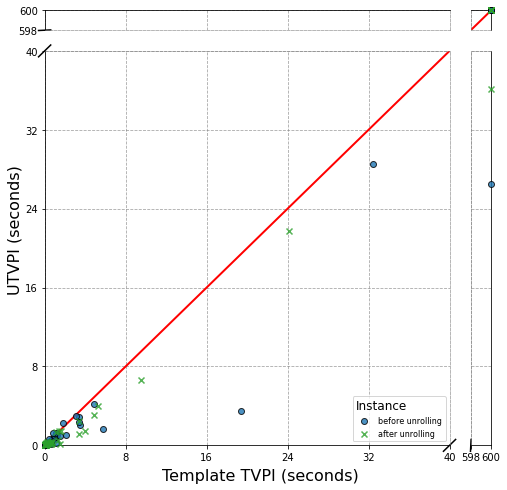

In [2729]:
time_plot = res[['job_name', 'template_tvpi_pp_time', 'template_tvpi_opsem_time', 'utvpi_pp_time', 'utvpi_opsem_time', 'pk_pp_time', 'pk_opsem_time']]
# print(time_plot[:1])
fig = plt.figure(figsize=(15, 12))
second_max = second_distinct_max(time_plot, ['template_tvpi_pp_time', 'template_tvpi_opsem_time', 'utvpi_pp_time', 'utvpi_opsem_time'])
print(second_max)
utvpi_test = time_plot[['template_tvpi_pp_time', 'template_tvpi_opsem_time', 'utvpi_pp_time', 'utvpi_opsem_time']]
scatter_with_axis_break(utvpi_test, 'utvpi', configurations, (0, int(math.ceil(second_max))), (TIMEOUT_THRESHOLD - 2, TIMEOUT_THRESHOLD))
# show_graph_2(time_plot, 'utvpi', int(round(second_max, 0)))
plt.savefig(f'SP_utvpi.png')

275.46


/tmp/ipykernel_1946912/3352680800.py:77: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_1946912/3352680800.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1080x864 with 0 Axes>

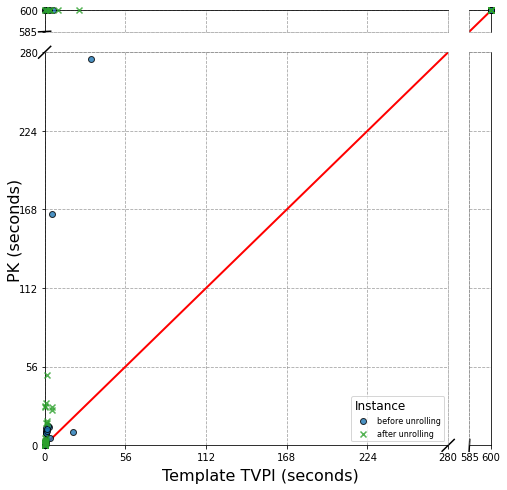

In [2730]:
fig = plt.figure(figsize=(15, 12))
second_max = second_distinct_max(time_plot, ['template_tvpi_pp_time', 'template_tvpi_opsem_time', 'pk_pp_time', 'pk_opsem_time'])
print(second_max)
pk_test = time_plot[['template_tvpi_pp_time', 'template_tvpi_opsem_time', 'pk_pp_time', 'pk_opsem_time']]
scatter_with_axis_break(pk_test, 'pk', configurations, (0, int(math.ceil(second_max))), (TIMEOUT_THRESHOLD - 15, TIMEOUT_THRESHOLD))
# show_graph_2(time_plot, 'pk', int(round(second_max, 0)))
plt.savefig(f'SP_pk.png')